In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
import torch
import numpy as np
import pandas as pd
import sklearn.metrics as mt
import matplotlib.pyplot as plt
import datetime

In [4]:
# 数据集加载 直接在GNN的数据集上修改 保证数据集的一致性
dataset = torch.load('/mnt/yzy/NIMCGCN/new_dataset.pt')
print(dataset.keys())
print(dataset['mm'].keys())
dataset = {
    'md': dataset['md_true'],
    'mm': dataset['mm']['data'],
    'dd': dataset['dd']['data'],
    'fold_one_index': dataset['fold_one_index'],
    'fold_zero_index': dataset['fold_zero_index'],
}
print(dataset.keys())
print(dataset['md'].shape)
print(dataset['mm'].shape)
print(dataset['dd'].shape)
print(dataset['fold_one_index'].shape)
print(dataset['fold_zero_index'].shape)

dict_keys(['md_p', 'md_true', 'mm', 'dd', 'fold_one_index', 'fold_zero_index'])
dict_keys(['data', 'edge_index'])
dict_keys(['md', 'mm', 'dd', 'fold_one_index', 'fold_zero_index'])
torch.Size([1043, 2166])
torch.Size([1043, 1043])
torch.Size([2166, 2166])
torch.Size([10, 2, 143])
torch.Size([10, 2, 225771])


In [5]:
# 转为numpy ndarray
md = dataset['md'].numpy()
mm = dataset['mm'].numpy()
dd = dataset['dd'].numpy()
fold_one_index = dataset['fold_one_index'].numpy()
fold_zero_index = dataset['fold_zero_index'].numpy()
print(md.shape)
print(mm.shape)
print(dd.shape)
print(fold_one_index.shape)
print(fold_zero_index.shape)

(1043, 2166)
(1043, 1043)
(2166, 2166)
(10, 2, 143)
(10, 2, 225771)


In [12]:
import numpy as np
from scipy.optimize import minimize

def matrix_completion(X_observed, rank):
    # X_observed: 已知的md关联数据矩阵
    # rank: 低秩矩阵的秩
    
    # 定义优化目标函数
    def objective_function(X):
        # 将矩阵X分解为两个低秩矩阵U和V的乘积
        U, S, V = np.linalg.svd(X.reshape(X_observed.shape))
        U = U[:, :rank]
        S = np.diag(S[:rank])
        V = V[:rank, :]
        
        # 计算核范数最小化目标函数的值
        loss = np.linalg.norm(X_observed - U @ S @ V, ord='fro')**2
        return loss
    
    # 初始化未知值的矩阵
    X_init = np.random.rand(*X_observed.shape)
    
    # 使用优化算法进行核范数最小化
    result = minimize(objective_function, X_init, method='CG')
    X_completed = result.x.reshape(X_observed.shape)
    
    return X_completed

# 示例用法
# 假设已知的md关联数据矩阵为X_observed
X_observed = md
print(X_observed.shape)

# 进行矩阵补全
rank = 2  # 低秩矩阵的秩
X_completed = matrix_completion(X_observed, rank)

print("补全后的矩阵:")
print(X_completed)


(1043, 2166)


/tmp/ipykernel_14268/875305753.py:24: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(objective_function, X_init, method='CG')


MemoryError: Unable to allocate 37.1 TiB for an array with shape (2259138, 2259138) and data type float64

1080750 0.4783904303322772
Best threshold: 0.03
0.6426729954833456


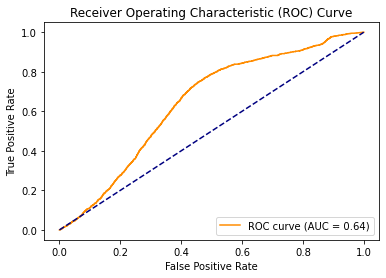

In [22]:
score = X_completed.reshape(-1)
label = md.reshape(-1)

fpr, tpr, thresholds = mt.roc_curve(label, score)
best_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_idx]

# 将模型输出映射为二分类标签
prediction = (score >= best_threshold).astype(int)
print(sum(prediction),sum(prediction)/2259138)
print(f'Best threshold: {best_threshold:.2f}')
# 计算 AUC
roc_auc = mt.auc(fpr, tpr)
print(roc_auc)
# 绘制 ROC 曲线
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

0.0008783877653982475


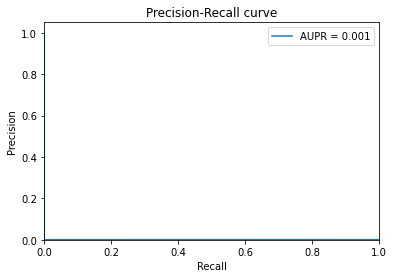

In [23]:
precision, recall, thresholds = mt.precision_recall_curve(label, score)
aupr = mt.auc(recall, precision)
print(aupr)
plt.plot(recall, precision, label='AUPR = %.3f' % aupr)
plt.fill_between(recall, precision, alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='upper right')
plt.show()

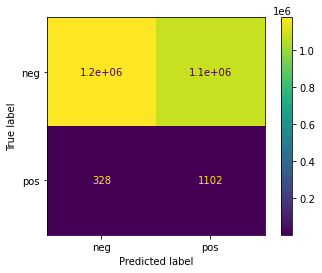

In [24]:
cm = mt.confusion_matrix(label,prediction)
disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','pos'])
disp.plot()
plt.show()